In [537]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import cookiedisaster
import gymnasium

from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Part 2 - Report

### Exercise 5 - Function Approximation and Policy Gradient

This task is most naturally described as continuing, as it has no explicit end-condition. We could continue forever.

Let's use linear approximation to approximate $q_\pi(a, s)$ and solve the control problem using Q-learning.

In [372]:
# Instantiate the cookie distaster environment
env = gymnasium.make('cookiedisaster/GridWorld-v0')

To be able to do function approximation we need to construct a feature vector out of the state-action-pair. This can be represented as the concatenation of all state and action values + some optional feature engineering.

In [373]:
def extract_features(state, action):
    agent, cookie = state["agent"], state["cookie"]
    state_vector = [agent["pos"], agent["vel"], cookie["pos"], cookie["time"]]

    # Create a one-hot-vector for action
    action_vector = [0] * 3
    action_vector[action] = 1

    # Let's also do some simple feature engineering (might or might not help learning)
    cookie_direction =[(cookie["pos"] - agent["pos"]) / abs(cookie["pos"] - agent["pos"])]
    planned_direction = [cookie_direction[0] * (action-1)]
    current_direction = [cookie_direction[0] * agent["vel"]]
    should_change_direction = [planned_direction[0] * current_direction[0]]

    return np.array(state_vector + action_vector + planned_direction + current_direction + should_change_direction)

def linear_approximate_q(weights, features):
    return np.dot(weights, features)

Then we can perform Q-learning with linear function approximation.

In [374]:
# Reset environment and extract feature vector size from initial observation
observation, info = env.reset()

# Hyperparameters
epsilon = 0.99
epsilon_floor = 0.01
epsilon_decay = 0.9995
gamma = 0.95
alpha = 0.01

episodes = 5000

# Store running cumulative reward
linear_cumulative_rewards = [0]

# Randomly initialize the weights 
linear_weights = np.random.rand(len(extract_features(observation, 0))) * 10

# And run Q-learning
for episode in range(episodes):
    # Find the action which maximizes Q-value (epsilon-delta)
    state = observation
    action = np.random.randint(3) if np.random.rand() < epsilon else np.argmax([linear_approximate_q(linear_weights, extract_features(state, a)) for a in range(3)])

    # Take the action and observe new state
    observation, reward, terminated, truncated, info = env.step(action)
    new_state = observation

    # Calculate the gradient
    delta_pi = (reward + gamma * np.max([linear_approximate_q(linear_weights, extract_features(new_state, a)) for a in range(3)]) - linear_approximate_q(linear_weights, extract_features(state, action))) * extract_features(state, action)

    # Perform a gradient ascent step
    linear_weights += alpha * delta_pi

    # Decay epsilon
    if epsilon > epsilon_floor:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_floor

    # Update cumulative rewards
    linear_cumulative_rewards.append(linear_cumulative_rewards[-1] + reward)

Now let's do the same but using a neural network for approximation.

First we need to define a suitable neural network.

In [375]:
class NN_approximate_q(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(10, 16)
        self.hidden1 = nn.Linear(16, 32)
        self.hidden2 = nn.Linear(32, 64)
        self.out = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.Tensor(x)

        # Pass through network
        out = F.relu(self.input(x))
        out = F.relu(self.hidden1(out))
        out = F.relu(self.hidden2(out))
        out = self.out(out)
        return out


Then let's perform Q-learning with it.

In [376]:
# Reset environment and extract feature vector size from initial observation
observation, info = env.reset()

# Hyperparameters
epsilon = 0.99
epsilon_floor = 0.01
epsilon_decay = 0.9995
gamma = 0.95
alpha = 0.01

episodes = 5000

# Store running cumulative reward
nn_cumulative_rewards = [0]

# Initialize a model, loss function and optimizer
model = NN_approximate_q()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=alpha)

# And run Q-learning
for episode in range(episodes):
    # Find the action which maximizes Q-value (epsilon-delta)
    state = observation
    action = np.random.randint(3) if np.random.rand() < epsilon else torch.argmax(torch.Tensor([model(extract_features(state, a)) for a in range(3)])).item()

    # Take the action and observe new state
    observation, reward, terminated, truncated, info = env.step(action)
    new_state = observation

    # Calculate the gradient and perform gradient descent step (within loss)
    left = reward + gamma * torch.max(torch.Tensor([model(extract_features(new_state, a)) for a in range(3)]))
    right = model(extract_features(state, action))
    loss = loss_fn(left, right)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay epsilon
    if epsilon > epsilon_floor:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_floor

    # Update cumulative rewards
    nn_cumulative_rewards.append(nn_cumulative_rewards[-1] + reward)

Plot and compare the cumulative rewards.

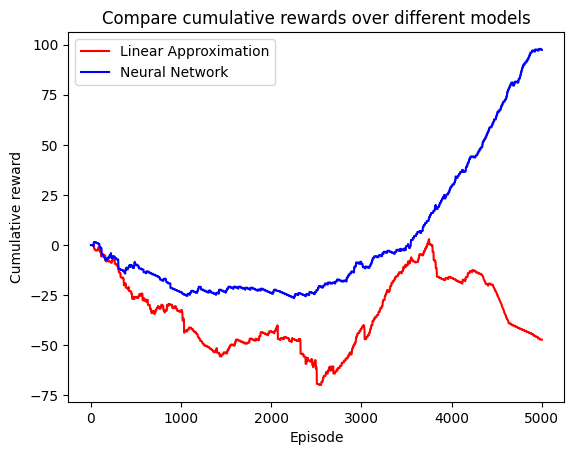

In [377]:
plt.plot(linear_cumulative_rewards, c="r", label="Linear Approximation")
plt.plot(nn_cumulative_rewards, c="b", label="Neural Network")
plt.title("Compare cumulative rewards over different models")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

------------------------------------------
### 4. (*)

Linear function approximation works by storing and iteratively updateing a vector of weights, which are dot-producted with a given feature vector (extracted from state and action) to approximate the Q-value $q_\pi(a, s)$. 

For neural networks the weight update is similar, however now we update them through backpropagation. Approximating it using neural networks also allow us to approximate non-linear functions, meaning if $q_\pi(a, s)$ we could possibly approximate it much better than using linear approximation.

For this task, cookie disaster, it seems plausible that the Q-value function $q_\pi(a, s)$ is non-linear, as the neural network does a way better job at the task than the linear approximation. Note that the linear is not very bad, it's just not very good either. The same cannot be said for the neural network, as it consistently chooses the correct actions for maximizing the reward!

------------------------------------------

Now let's try to implement an actor-critic model to directly learn an optimal policy $\pi(a|s)$.

We now need two new network architectures, an actor and a critic.

In [604]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(5, 16)
        self.hidden1 = nn.Linear(16, 32)
        self.hidden2 = nn.Linear(32, 64)
        self.out = nn.Linear(64, 3)
    
    def forward(self, x):
        x = torch.Tensor(x)

        # Pass through network
        out = F.relu(self.input(x))
        out = F.relu(self.hidden1(out))
        out = F.relu(self.hidden2(out))
        
        # Output probabilities for actor
        out = F.softmax(self.out(out), dim=0)
        return out


In [699]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(10, 16)
        self.hidden1 = nn.Linear(16, 32)
        self.hidden2 = nn.Linear(32, 64)
        self.out = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.Tensor(x)

        # Pass through network
        out = F.relu(self.input(x))
        out = F.relu(self.hidden1(out))
        out = F.relu(self.hidden2(out))
        
        # Output q-value for critic
        out = self.out(out)
        return out


Now we also do not need to add the wanted action to our feature vector.

In [601]:
def actor_extract_features(state):
    agent, cookie = state["agent"], state["cookie"]
    state_vector = [agent["pos"], agent["vel"], cookie["pos"], cookie["time"]]

    # Let's also do some simple feature engineering (might or might not help learning)
    cookie_direction =[(cookie["pos"] - agent["pos"]) / abs(cookie["pos"] - agent["pos"])]
    current_direction = [cookie_direction[0] * agent["vel"]]

    return np.array(state_vector + current_direction)

Then we can train the model.

In [858]:
# Reset environment and extract feature vector size from initial observation
observation, info = env.reset()

# Hyperparameters
epsilon = 0.99
epsilon_floor = 0.01
epsilon_decay = 0.9995
gamma = 0.95
alpha = 0.01

episodes = 5000

# Store running cumulative reward
ac_cumulative_rewards = [0]

# Initialize a model, target and optimizer
actor = Actor()
critic = Critic()
optimizer_actor = optim.SGD(actor.parameters(), lr=alpha)
optimizer_critic = optim.SGD(critic.parameters(), lr=alpha)

# And run Q-learning
for episode in range(episodes):
    # Find the action with highest probability in policy (epsilon-delta)
    state = observation
    probabilities = actor(actor_extract_features(state))
    action = np.random.randint(3) if np.random.rand() < epsilon else torch.argmax(probabilities).item()
    q_value = critic(extract_features(state, action))

    # Take the action and observe new state
    observation, reward, terminated, truncated, info = env.step(action)
    new_state = observation

    # Calculate each part's loss and perform a gradient descent (ascent) step
    delta_v = reward + gamma * torch.max(torch.tensor([critic(extract_features(new_state, a)) for a in range(3)])).detach() - q_value

    actor_loss = -(torch.log(probabilities) * delta_v.detach()).sum()
    critic_loss = torch.pow(delta_v, 2)

    optimizer_actor.zero_grad()
    actor_loss.backward()
    optimizer_actor.step()
    
    optimizer_critic.zero_grad()
    critic_loss.backward()
    optimizer_critic.step()

    # Decay epsilon
    if epsilon > epsilon_floor:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_floor

    # Update cumulative rewards
    ac_cumulative_rewards.append(ac_cumulative_rewards[-1] + reward)

And plot the actor-critic model's cumulative rewards against the others.

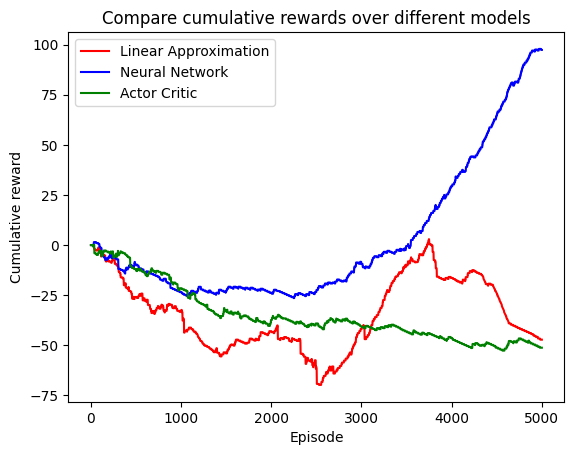

In [859]:
plt.plot(linear_cumulative_rewards, c="r", label="Linear Approximation")
plt.plot(nn_cumulative_rewards, c="b", label="Neural Network")
plt.plot(ac_cumulative_rewards, c="g", label="Actor Critic")
plt.title("Compare cumulative rewards over different models")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

------------------------------------------
### 6. (*)

The actor-critic model works by having two different networks. The actor network, responsible for approximating the policy $\pi(a|s)$, and a critic network, responsible for approximating the value of a state/action.

These two work together in training the actor network. The actor picks the action it thinks is the optimal, and the critic its own evaluation to either criticize or reward the actors choice of action.

When comparing it to the others we see that it does slightly better than the linear approximation, but worse than the neural network approximation. This is because the actor-critic algorithm suffers from the deadly triad. There are several things one could do to improve the learning of this algorithm, such as parallellism, synchronization, target networks, replay buffers, etc.
Including any of these would greatly increase the efficiency of this model.

------------------------------------------